# Time Series Analysis 

# 1.Plot the Time Series:  Visualize the time series data to identify patterns,      trends, and potential anomalies.
# 2.Check for Stationarity: Assess stationarity using statistical tests like the Augmented Dickey-Fuller (ADF) test to determine if the mean and variance are constant over time. 
# 3. Apply Log Transformation: Reduce variability in the data by applying a log transformation, which helps stabilize the variance.
# 4. Differencing: Apply differencing techniques to make the time series stationary, ensuring the model assumptions are met.
# 5. Analyze Autocorrelation and Partial Autocorrelation (ACF & PACF): Examine ACF and PACF plots to identify lag dependencies and guide model selection.
# 6. Train-Test Split: Divide the dataset into training and testing sets for model building and validation.
# 7. Time Series Decomposition: Break down the series into its trend, seasonal, and residual components for better insight into its behavior.
# 8.Feature Engineering: Engineer additional features like lag variables, rolling mean, and rolling standard deviation to capture hidden patterns in the data.
# 9. Find Optimal SARIMA Parameters (Auto ARIMA): Use automated methods to identify the best-fit parameters for the SARIMA model.
# 10. Generate Forecasts: Predict future values for the test period and evaluate model accuracy using error metrics. 

# Importing Libraries and Loading the Dataset

In [1]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import statsmodels.api as sm  # For advanced statistical modeling
from statsmodels.tsa.seasonal import seasonal_decompose  # For time series decomposition
from pmdarima import auto_arima  # For automatic selection of ARIMA parameters
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For evaluating model performance
from statsmodels.tsa.stattools import adfuller  # For stationarity testing

# Define the file path to the dataset
dataset_file_path = "C:\\Users\\malav\\Downloads\\Statistics and Optimisation\\ts9.csv"

# Load the dataset into a pandas DataFrame

time_series_data = pd.read_csv(dataset_file_path)



In [2]:

# Display basic information about the dataset
print(time_series_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  401 non-null    int64  
 1   x           401 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB
None


# Data Cleaning

In [3]:
# Check for missing values in the dataset and display the count per column
missing_values_count = time_series_data.isnull().sum()
print(f"Missing values in the dataset:\n{missing_values_count}")

# Check for duplicate rows in the dataset and display the count
duplicate_rows_count = time_series_data.duplicated().sum()
print(f"Number of duplicate rows in the dataset: {duplicate_rows_count}")

# Optional: Drop duplicate rows if any exist

if duplicate_rows_count > 0:
    time_series_data = time_series_data.drop_duplicates()
    print(f"Duplicate rows have been removed. Updated dataset shape: {time_series_data.shape}")


Missing values in the dataset:
Unnamed: 0    0
x             0
dtype: int64
Number of duplicate rows in the dataset: 0


# 1.Plot the Time Series

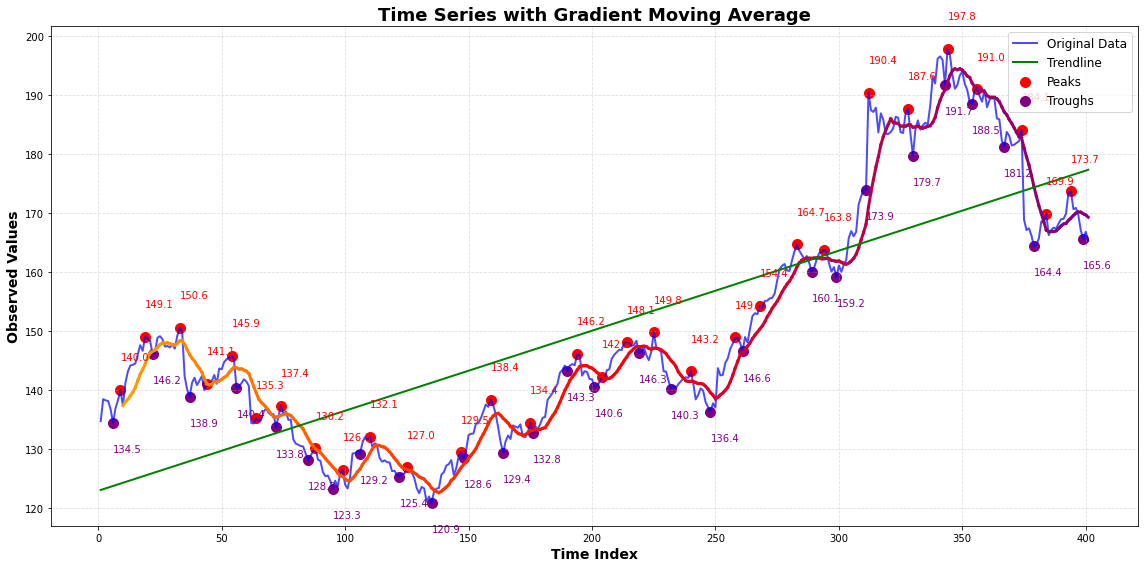

In [4]:
from scipy.signal import find_peaks
from matplotlib.colors import LinearSegmentedColormap

# Set the index and rename columns for better understanding
time_series_data.set_index('Unnamed: 0', inplace=True)  # Set the 'Unnamed: 0' column as the index
time_series_data.index.name = 'Time Index'  # Rename the index to 'Time Index'
time_series_data.rename(columns={'x': 'Observed Values'}, inplace=True)  # Rename the column 'x' to 'Observed Values'

# Calculate a moving average for smoothing the data
moving_average_window = 10  # Define the window size for the moving average
time_series_data['Moving Average'] = time_series_data['Observed Values'].rolling(window=moving_average_window).mean()

# Calculate a linear trendline to observe the general direction of the data
linear_fit_coefficients = np.polyfit(range(len(time_series_data)), time_series_data['Observed Values'], 1)
linear_trendline = np.poly1d(linear_fit_coefficients)(range(len(time_series_data)))

# Identify peaks (local maxima) and troughs (local minima) in the time series
peak_indices, _ = find_peaks(time_series_data['Observed Values'], distance=10)  # Peaks (local maxima)
trough_indices, _ = find_peaks(-time_series_data['Observed Values'], distance=10)  # Troughs (local minima)

# Create a color gradient for the moving average
color_gradient = LinearSegmentedColormap.from_list("CustomGradient", ["orange", "red", "purple"], N=256)
gradient_intensity = np.linspace(0, 1, len(time_series_data['Moving Average']))
gradient_intensity = np.nan_to_num(gradient_intensity)  # Replace NaN values in the gradient

# Start plotting the enhanced time series visualization
plt.figure(figsize=(16, 8))

# Plot the original time series data
plt.plot(time_series_data['Observed Values'], label='Original Data', color='blue', alpha=0.7, linewidth=2)

# Plot the moving average with a color gradient
for i in range(len(time_series_data) - 1):
    if not np.isnan(time_series_data['Moving Average'].iloc[i:i + 2]).any():
        plt.plot(
            time_series_data.index[i:i + 2],
            time_series_data['Moving Average'].iloc[i:i + 2],
            color=color_gradient(gradient_intensity[i]),
            linewidth=3,
        )

# Plot the linear trendline
plt.plot(time_series_data.index, linear_trendline, color='green', label='Trendline', linewidth=2)

# Highlight peaks and troughs in the time series
plt.scatter(time_series_data.index[peak_indices], time_series_data['Observed Values'].iloc[peak_indices], color='red', s=100, label='Peaks')
plt.scatter(time_series_data.index[trough_indices], time_series_data['Observed Values'].iloc[trough_indices], color='purple', s=100, label='Troughs')

# Annotate peaks and troughs with their values
for peak in peak_indices:
    plt.text(time_series_data.index[peak], time_series_data['Observed Values'].iloc[peak] + 5, 
             f'{time_series_data["Observed Values"].iloc[peak]:.1f}', color='red', fontsize=10)
for trough in trough_indices:
    plt.text(time_series_data.index[trough], time_series_data['Observed Values'].iloc[trough] - 5, 
             f'{time_series_data["Observed Values"].iloc[trough]:.1f}', color='purple', fontsize=10)

# Add title, labels, and formatting
plt.title('Time Series with Gradient Moving Average', fontsize=18, fontweight='bold')  # Add title
plt.xlabel('Time Index', fontsize=14, fontweight='bold')  # Add x-axis label
plt.ylabel('Observed Values', fontsize=14, fontweight='bold')  # Add y-axis label

# Add a grid, legend, and adjust layout for better visibility
plt.grid(alpha=0.4, linestyle="--")  # Add a grid
plt.legend(fontsize=12)  # Add legend
plt.tight_layout()  # Adjust layout to prevent overlap

# Display the final plot
plt.show()


# 2.Check for Stationarity

In [5]:
# Function to perform the Augmented Dickey-Fuller (ADF) test for stationarity
def check_stationarity(time_series):
    """
    Perform the Augmented Dickey-Fuller (ADF) test on a time series to check stationarity.

    Parameters:
    - time_series: A pandas Series object representing the time series data.

    Prints:
    - ADF Statistic
    - p-value
    - Stationarity status (stationary or non-stationary)
    """
    adf_result = adfuller(time_series, autolag='AIC')  # Perform ADF test with AIC-based lag selection
    print('ADF Statistic:', adf_result[0])  # Test statistic
    print('p-value:', adf_result[1])  # p-value to determine stationarity

    # Interpret the p-value
    if adf_result[1] > 0.05:
        print("The series is non-stationary. Consider differencing or transformations.")
    else:
        print("The series is stationary. Proceed with modeling.")

# Perform the ADF test on the 'Observed Values' column of the dataset
check_stationarity(time_series_data['Observed Values'])


ADF Statistic: -0.9967272028387213
p-value: 0.7544561062660518
The series is non-stationary. Consider differencing or transformations.


# 3. Apply Log Transformation


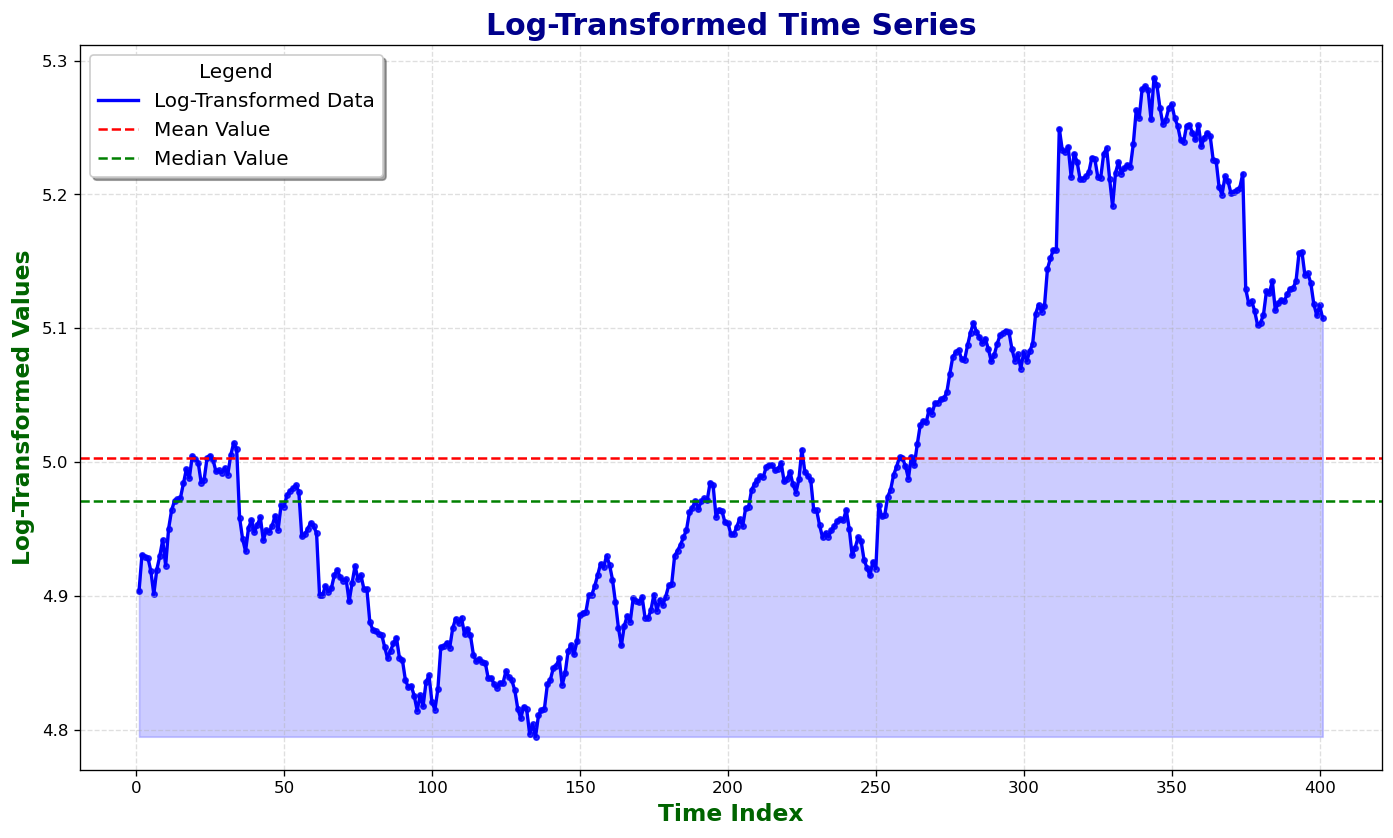

ADF Statistic: -0.9535799835972384
p-value: 0.7698164047587062
The series is non-stationary. Consider differencing or transformations.


In [6]:
# Apply log transformation to stabilize variance
log_transformed_data = np.log(time_series_data['Observed Values'])

# Plot the log-transformed time series data
plt.figure(figsize=(14, 8), dpi=120)  # Set the figure size and resolution for a premium look

# Plot the log-transformed data with a gradient fill for visual enhancement
plt.plot(log_transformed_data, color='blue', linewidth=2, label='Log-Transformed Data')
plt.fill_between(log_transformed_data.index, log_transformed_data, 
                 log_transformed_data.min(), color='blue', alpha=0.2)

# Add data point markers to make the plot more engaging
plt.scatter(log_transformed_data.index, log_transformed_data, color='blue', s=10, alpha=0.8)

# Add title and labels with customized fonts and styles
plt.title('Log-Transformed Time Series', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Time Index', fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel('Log-Transformed Values', fontsize=14, fontweight='bold', color='darkgreen')

# Add a grid for readability with custom line style
plt.grid(alpha=0.4, linestyle='--')

# Highlight important features of the time series
plt.axhline(log_transformed_data.mean(), color='red', linestyle='--', linewidth=1.5, label='Mean Value')
plt.axhline(log_transformed_data.median(), color='green', linestyle='--', linewidth=1.5, label='Median Value')

# Add a legend with a premium style
plt.legend(fontsize=12, frameon=True, shadow=True, loc='upper left', title='Legend', title_fontsize=12)

# Show the enhanced plot
plt.show()

# Perform the ADF test on the log-transformed data to check stationarity
check_stationarity(log_transformed_data)


# 4. Differencing

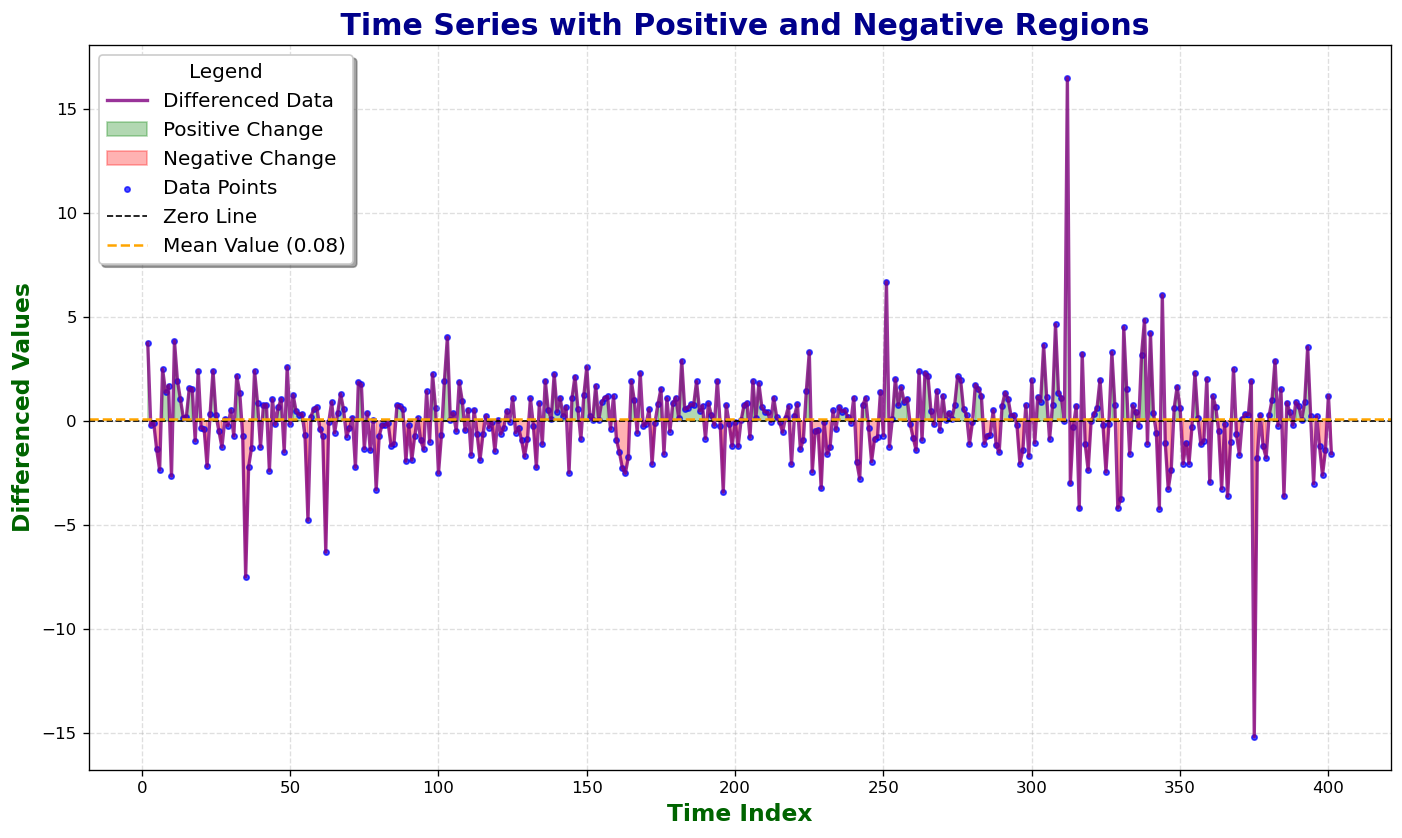

In [16]:
# Apply first-order differencing to the time series to achieve stationarity
differenced_data = time_series_data['Observed Values'].diff().dropna()
differenced_data = pd.DataFrame(differenced_data, columns=['Observed Values'])

# Re-check stationarity after differencing using ADF test (if needed)
# Uncomment the next line if you want to perform an ADF test
# check_stationarity(differenced_data['Observed Values'])

# Plot the differenced time series data with enhancements
plt.figure(figsize=(14, 8), dpi=120)  # Set figure size and resolution

# Plot the differenced data with custom styling
plt.plot(differenced_data.index, differenced_data['Observed Values'], 
         color='purple', linewidth=2, label='Differenced Data', alpha=0.8)

# Highlight positive and negative regions using different shades
plt.fill_between(differenced_data.index, differenced_data['Observed Values'], 0, 
                 where=(differenced_data['Observed Values'] > 0), 
                 color='green', alpha=0.3, label='Positive Change')
plt.fill_between(differenced_data.index, differenced_data['Observed Values'], 0, 
                 where=(differenced_data['Observed Values'] < 0), 
                 color='red', alpha=0.3, label='Negative Change')

# Add markers for peaks and troughs
plt.scatter(differenced_data.index, differenced_data['Observed Values'], 
            color='blue', s=10, alpha=0.7, label='Data Points')

# Add mean and zero reference lines for context
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Line')
plt.axhline(differenced_data['Observed Values'].mean(), color='orange', linestyle='--', linewidth=1.5, 
            label=f"Mean Value ({differenced_data['Observed Values'].mean():.2f})")

# Title and axis labels with premium styling
plt.title(' Time Series with Positive and Negative Regions', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Time Index', fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel('Differenced Values', fontsize=14, fontweight='bold', color='darkgreen')

# Add grid for better readability
plt.grid(alpha=0.4, linestyle='--')

# Add a styled legend
plt.legend(fontsize=12, frameon=True, shadow=True, loc='upper left', title='Legend', title_fontsize=12)

# Display the enhanced plot
plt.show()




In [8]:
# Perform ADF test on the differenced data to check stationarity
check_stationarity(differenced_data['Observed Values'])

# Display the differenced data
differenced_data


ADF Statistic: -20.36761411881924
p-value: 0.0
The series is stationary. Proceed with modeling.


,Observed Values
Time Index,
2,3.739990
3,-0.220001
4,-0.089996
5,-1.369995
6,-2.360001
...,...
397,-1.229996
398,-2.610001
399,-1.419998


# 5. Analyze Autocorrelation and Partial Autocorrelation

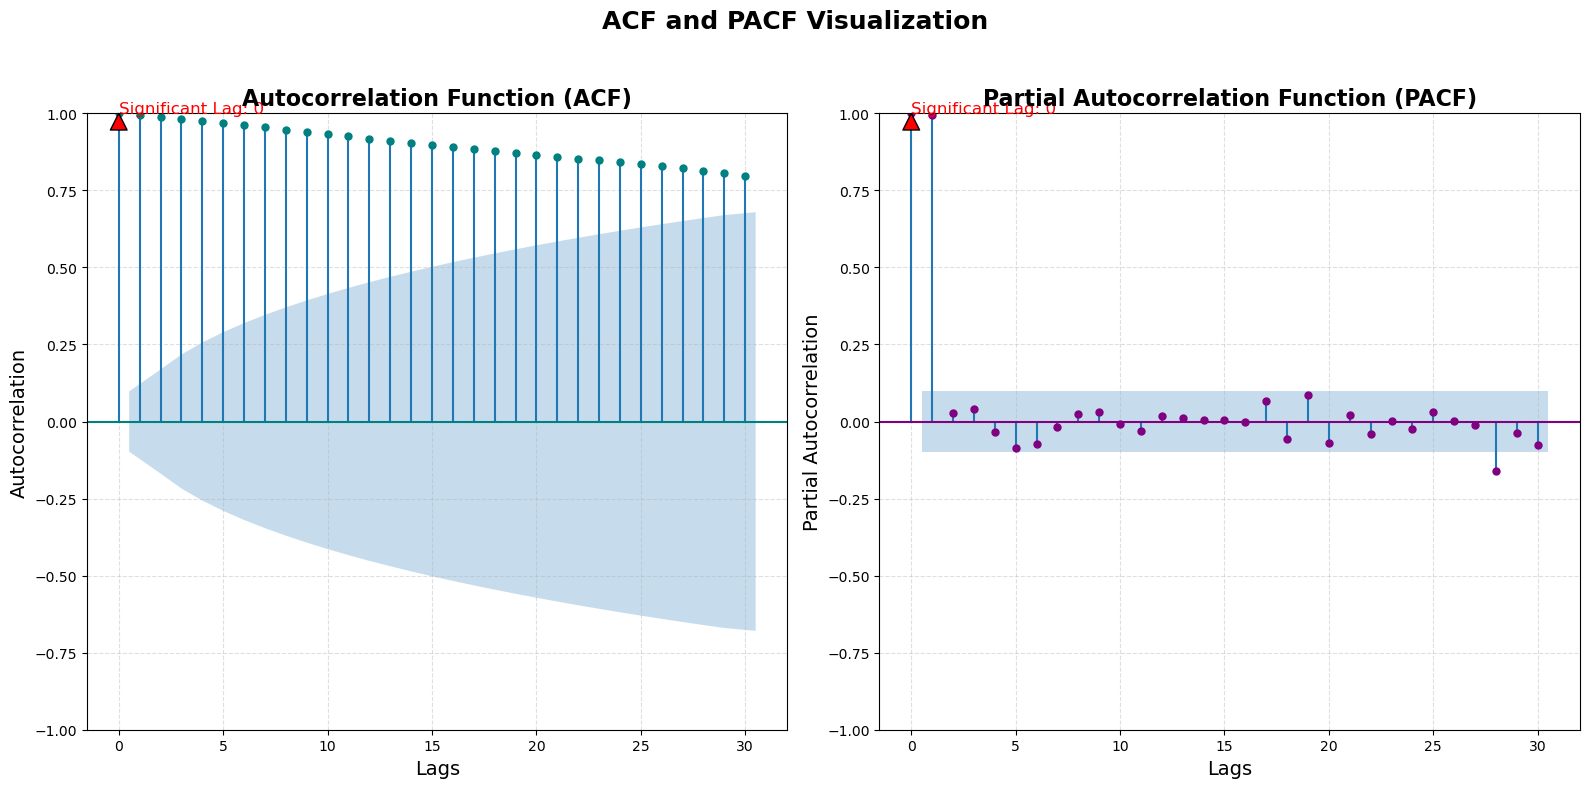

In [9]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF values numerically for the observed values
acf_values = acf(time_series_data['Observed Values'], nlags=30, fft=True)  # Compute ACF for 30 lags
pacf_values = pacf(time_series_data['Observed Values'], nlags=30, method='ywm')  # Compute PACF for 30 lags

# Prepare a combined figure for ACF and PACF visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=100)

# Enhanced ACF Plot
plot_acf(time_series_data['Observed Values'], lags=30, alpha=0.05, ax=axes[0], color='teal')  # ACF plot
axes[0].set_title("Autocorrelation Function (ACF)", fontsize=16, fontweight='bold')  # Set title for ACF
axes[0].set_xlabel("Lags", fontsize=14)  # Label for x-axis
axes[0].set_ylabel("Autocorrelation", fontsize=14)  # Label for y-axis
axes[0].grid(alpha=0.4, linestyle="--")  # Add grid for better readability

# Annotate the most significant lag for ACF
significant_lag_acf = np.argmax(np.abs(acf_values) > 0.5)  # Adjust threshold as needed
axes[0].annotate(f"Significant Lag: {significant_lag_acf}", 
                 (significant_lag_acf, acf_values[significant_lag_acf]), 
                 fontsize=12, color="red", 
                 arrowprops=dict(facecolor='red', shrink=1.5))

# Enhanced PACF Plot
plot_pacf(time_series_data['Observed Values'], lags=30, alpha=0.05, ax=axes[1], method='ywm', color='purple')  # PACF plot
axes[1].set_title("Partial Autocorrelation Function (PACF)", fontsize=16, fontweight='bold')  # Set title for PACF
axes[1].set_xlabel("Lags", fontsize=14)  # Label for x-axis
axes[1].set_ylabel("Partial Autocorrelation", fontsize=14)  # Label for y-axis
axes[1].grid(alpha=0.4, linestyle="--")  # Add grid for better readability

# Annotate the most significant lag for PACF
significant_lag_pacf = np.argmax(np.abs(pacf_values) > 0.5)  # Adjust threshold as needed
axes[1].annotate(f"Significant Lag: {significant_lag_pacf}", 
                 (significant_lag_pacf, pacf_values[significant_lag_pacf]), 
                 fontsize=12, color="red", 
                 arrowprops=dict(facecolor='red', shrink=1.5))

# Add a common title for the figure
plt.suptitle("ACF and PACF Visualization", fontsize=18, fontweight='bold')  # Add a shared title
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# 6. Train-Test Split

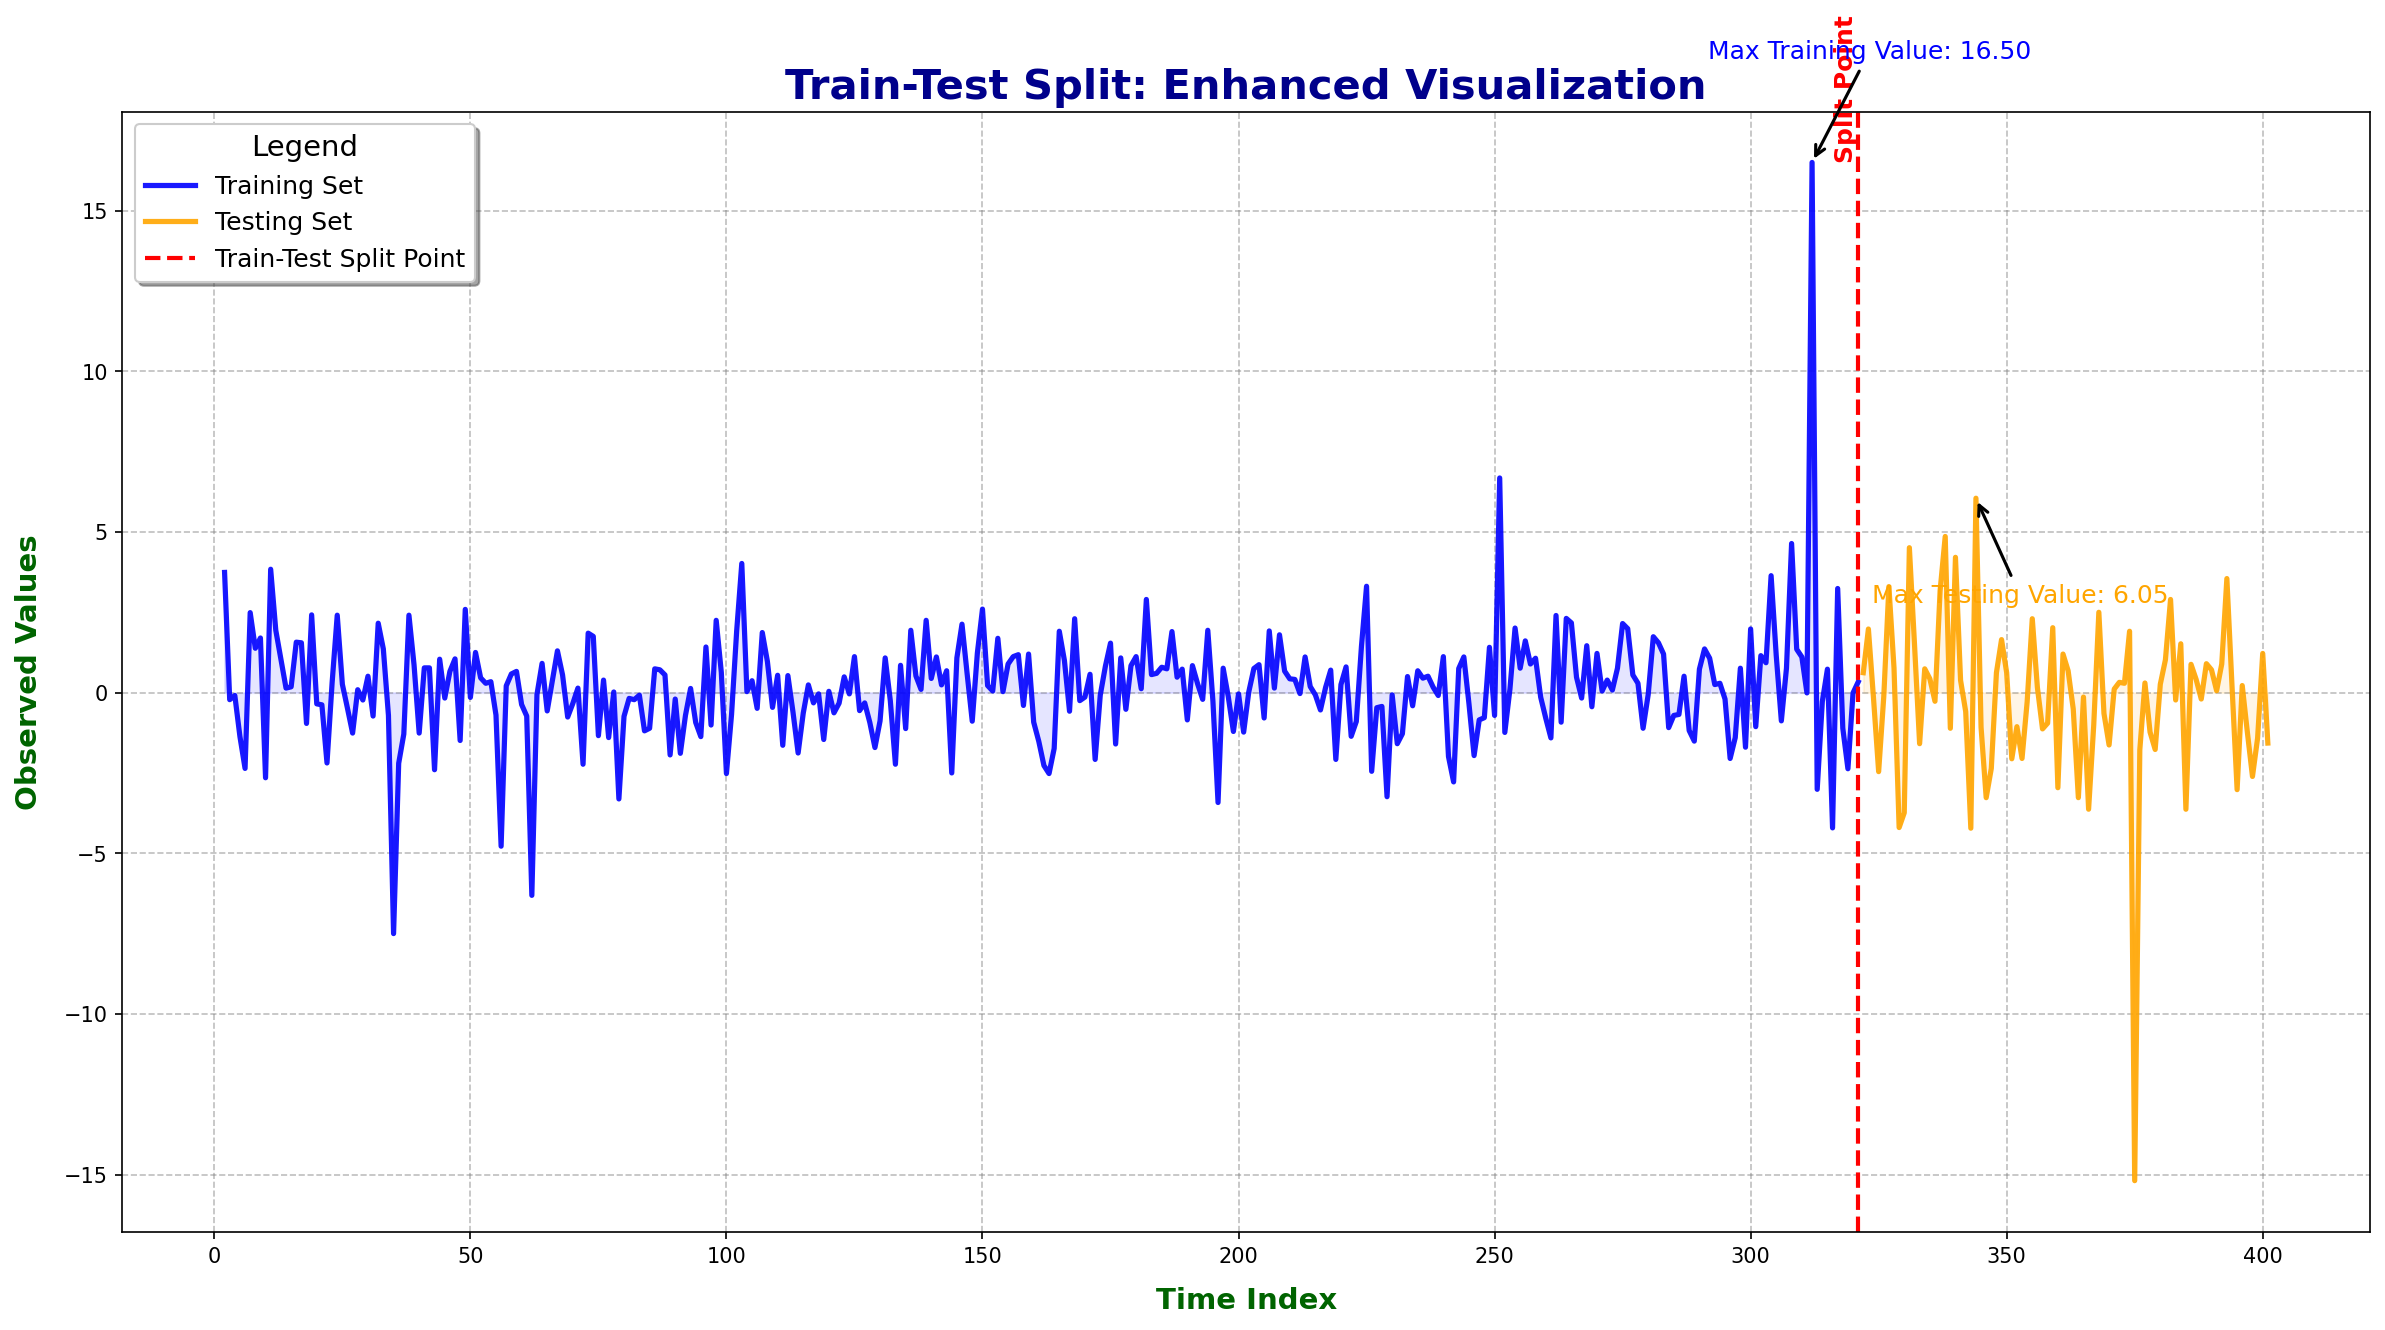

In [10]:
# Split differenced data into training (80%) and testing (20%) sets
train_size = int(len(differenced_data) * 0.8)
train = differenced_data[:train_size]
test = differenced_data[train_size:]

# Plot the training and testing sets with advanced visualization
plt.figure(figsize=(16, 9), dpi=150)  # High resolution and large figure size for professional quality

# Plot training data with a smooth line and gradient fill
plt.plot(train.index, train.values, label='Training Set', color='blue', linewidth=2.5, alpha=0.9)
plt.fill_between(train.index, train.values.flatten(), color='blue', alpha=0.1, label='_nolegend_')

# Plot testing data with a smooth line and gradient fill
plt.plot(test.index, test.values, label='Testing Set', color='orange', linewidth=2.5, alpha=0.9)
plt.fill_between(test.index, test.values.flatten(), color='orange', alpha=0.1, label='_nolegend_')

# Highlight the train-test split point with a vertical line and annotation
split_point = train.index[-1]
plt.axvline(split_point, color='red', linestyle='--', linewidth=2, label='Train-Test Split Point')
plt.text(split_point, max(train.values.max(), test.values.max()), 'Split Point', 
         color='red', fontsize=12, fontweight='bold', ha='right', va='bottom', rotation=90)

# Add gridlines with subtle styling for better readability
plt.grid(alpha=0.5, linestyle='--', linewidth=0.8, color='gray')

# Add title and labels with enhanced font properties
plt.title('Train-Test Split: Enhanced Visualization', fontsize=20, fontweight='bold', color='darkblue', loc='center')
plt.xlabel('Time Index', fontsize=14, fontweight='bold', color='darkgreen', labelpad=10)
plt.ylabel('Observed Values', fontsize=14, fontweight='bold', color='darkgreen', labelpad=10)

# Annotate key points in the data for extra clarity (optional)
plt.annotate(f'Max Training Value: {train.values.max():.2f}', 
             xy=(train.index[train.values.argmax()], train.values.max()), 
             xytext=(-50, 50), textcoords='offset points',
             arrowprops=dict(facecolor='blue', arrowstyle='->', linewidth=1.5),
             fontsize=12, color='blue')
plt.annotate(f'Max Testing Value: {test.values.max():.2f}', 
             xy=(test.index[test.values.argmax()], test.values.max()), 
             xytext=(-50, -50), textcoords='offset points',
             arrowprops=dict(facecolor='orange', arrowstyle='->', linewidth=1.5),
             fontsize=12, color='orange')

# Add a professional legend with shadow and frame
plt.legend(fontsize=12, frameon=True, shadow=True, loc='upper left', title='Legend', title_fontsize=14)

# Adjust layout for a cleaner, professional presentation
plt.tight_layout()

# Show the enhanced plot
plt.show()


# 7. Time Series Decomposition

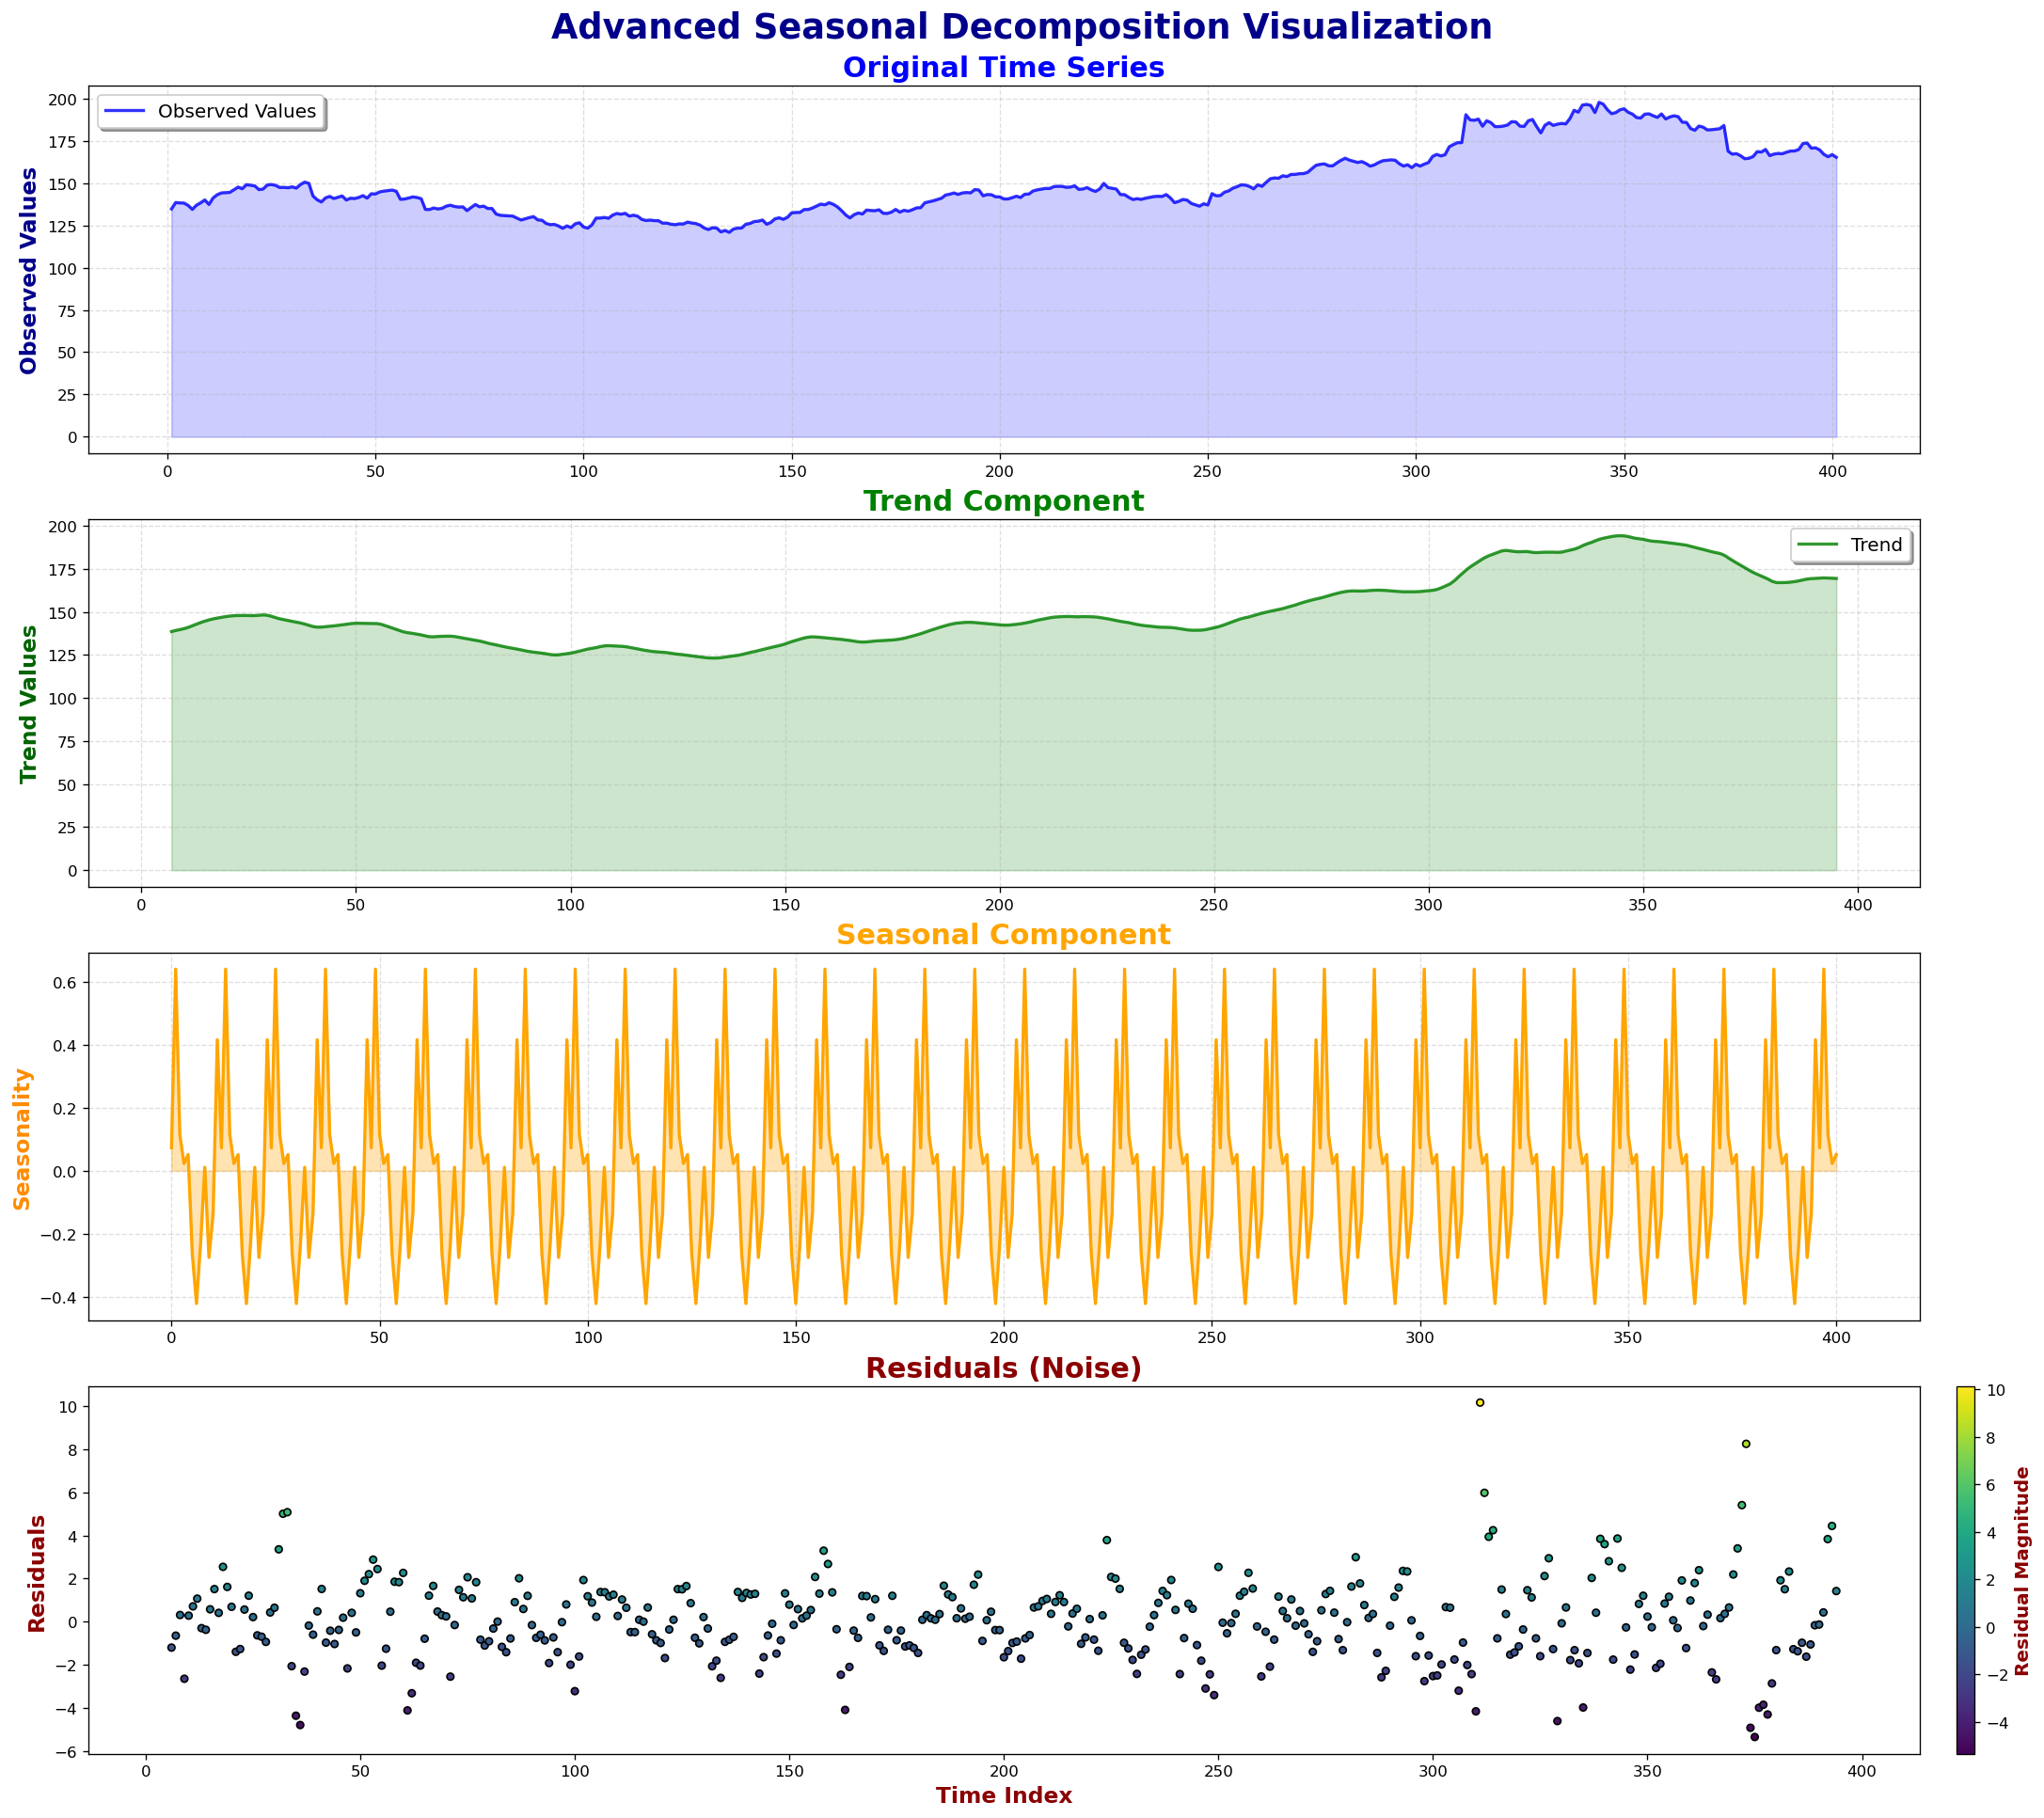

In [11]:
import warnings
from matplotlib import MatplotlibDeprecationWarning
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

# Perform seasonal decomposition
decomposition = seasonal_decompose(time_series_data['Observed Values'], period=12, model='additive')

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
observed = time_series_data['Observed Values']

# Create a color palette for enhanced visuals
cmap = sns.color_palette("viridis", as_cmap=True)

# Set up a figure with a modern layout
fig, axes = plt.subplots(4, 1, figsize=(18, 16), dpi=120, constrained_layout=True)

# Plot the Original Series with gradient fill
axes[0].plot(observed, color="blue", linewidth=2, alpha=0.8, label='Observed Values')
axes[0].fill_between(observed.index, observed, alpha=0.2, color="blue")
axes[0].set_title("Original Time Series", fontsize=18, fontweight="bold", color="blue")
axes[0].set_ylabel("Observed Values", fontsize=14, fontweight="bold", color="darkblue")
axes[0].grid(alpha=0.4, linestyle="--")
axes[0].legend(fontsize=12, frameon=True, shadow=True)

# Plot the Trend Component with highlight
axes[1].plot(trend, color="green", linewidth=2, alpha=0.8, label='Trend')
axes[1].fill_between(trend.index, trend, alpha=0.2, color="green")
axes[1].set_title("Trend Component", fontsize=18, fontweight="bold", color="green")
axes[1].set_ylabel("Trend Values", fontsize=14, fontweight="bold", color="darkgreen")
axes[1].grid(alpha=0.4, linestyle="--")
axes[1].legend(fontsize=12, frameon=True, shadow=True)

# Plot the Seasonal Component with a ribbon effect
sns.lineplot(x=range(len(seasonal)), y=seasonal, color="orange", ax=axes[2], linewidth=2)
axes[2].fill_between(range(len(seasonal)), seasonal, alpha=0.3, color="orange")
axes[2].set_title("Seasonal Component", fontsize=18, fontweight="bold", color="orange")
axes[2].set_ylabel("Seasonality", fontsize=14, fontweight="bold", color="darkorange")
axes[2].grid(alpha=0.4, linestyle="--")

# Plot the Residuals with scatter plot and gradient
axes[3].grid(False)
scatter = axes[3].scatter(range(len(residual)), residual, c=residual, cmap=cmap, s=20, edgecolor="black")
axes[3].set_title("Residuals (Noise)", fontsize=18, fontweight="bold", color="darkred")
axes[3].set_xlabel("Time Index", fontsize=14, fontweight="bold", color="darkred")
axes[3].set_ylabel("Residuals", fontsize=14, fontweight="bold", color="darkred")

# Add a color bar for residuals
cbar = fig.colorbar(scatter, ax=axes[3], orientation='vertical', pad=0.02)
cbar.set_label('Residual Magnitude', fontsize=12, fontweight="bold", color="darkred")

# Add a global title
plt.suptitle("Advanced Seasonal Decomposition Visualization", fontsize=22, fontweight="bold", color="darkblue")

# Display the plot
plt.show()


# 8.Feature Engineering

First few rows with newly engineered features (Lag, Rolling Mean, Rolling Std):
            Observed Values  Moving Average       Lag_1  Rolling_Mean  \
Time Index                                                              
1                134.770004             NaN         NaN           NaN   
2                138.509995             NaN  134.770004           NaN   
3                138.289993             NaN  138.509995           NaN   
4                138.199997             NaN  138.289993           NaN   
5                136.830002             NaN  138.199997           NaN   
6                134.470001             NaN  136.830002           NaN   
7                136.960007             NaN  134.470001           NaN   
8                138.339996             NaN  136.960007           NaN   
9                140.039993             NaN  138.339996           NaN   
10               137.389999      137.379999  140.039993           NaN   
11               141.229996      138.025998 

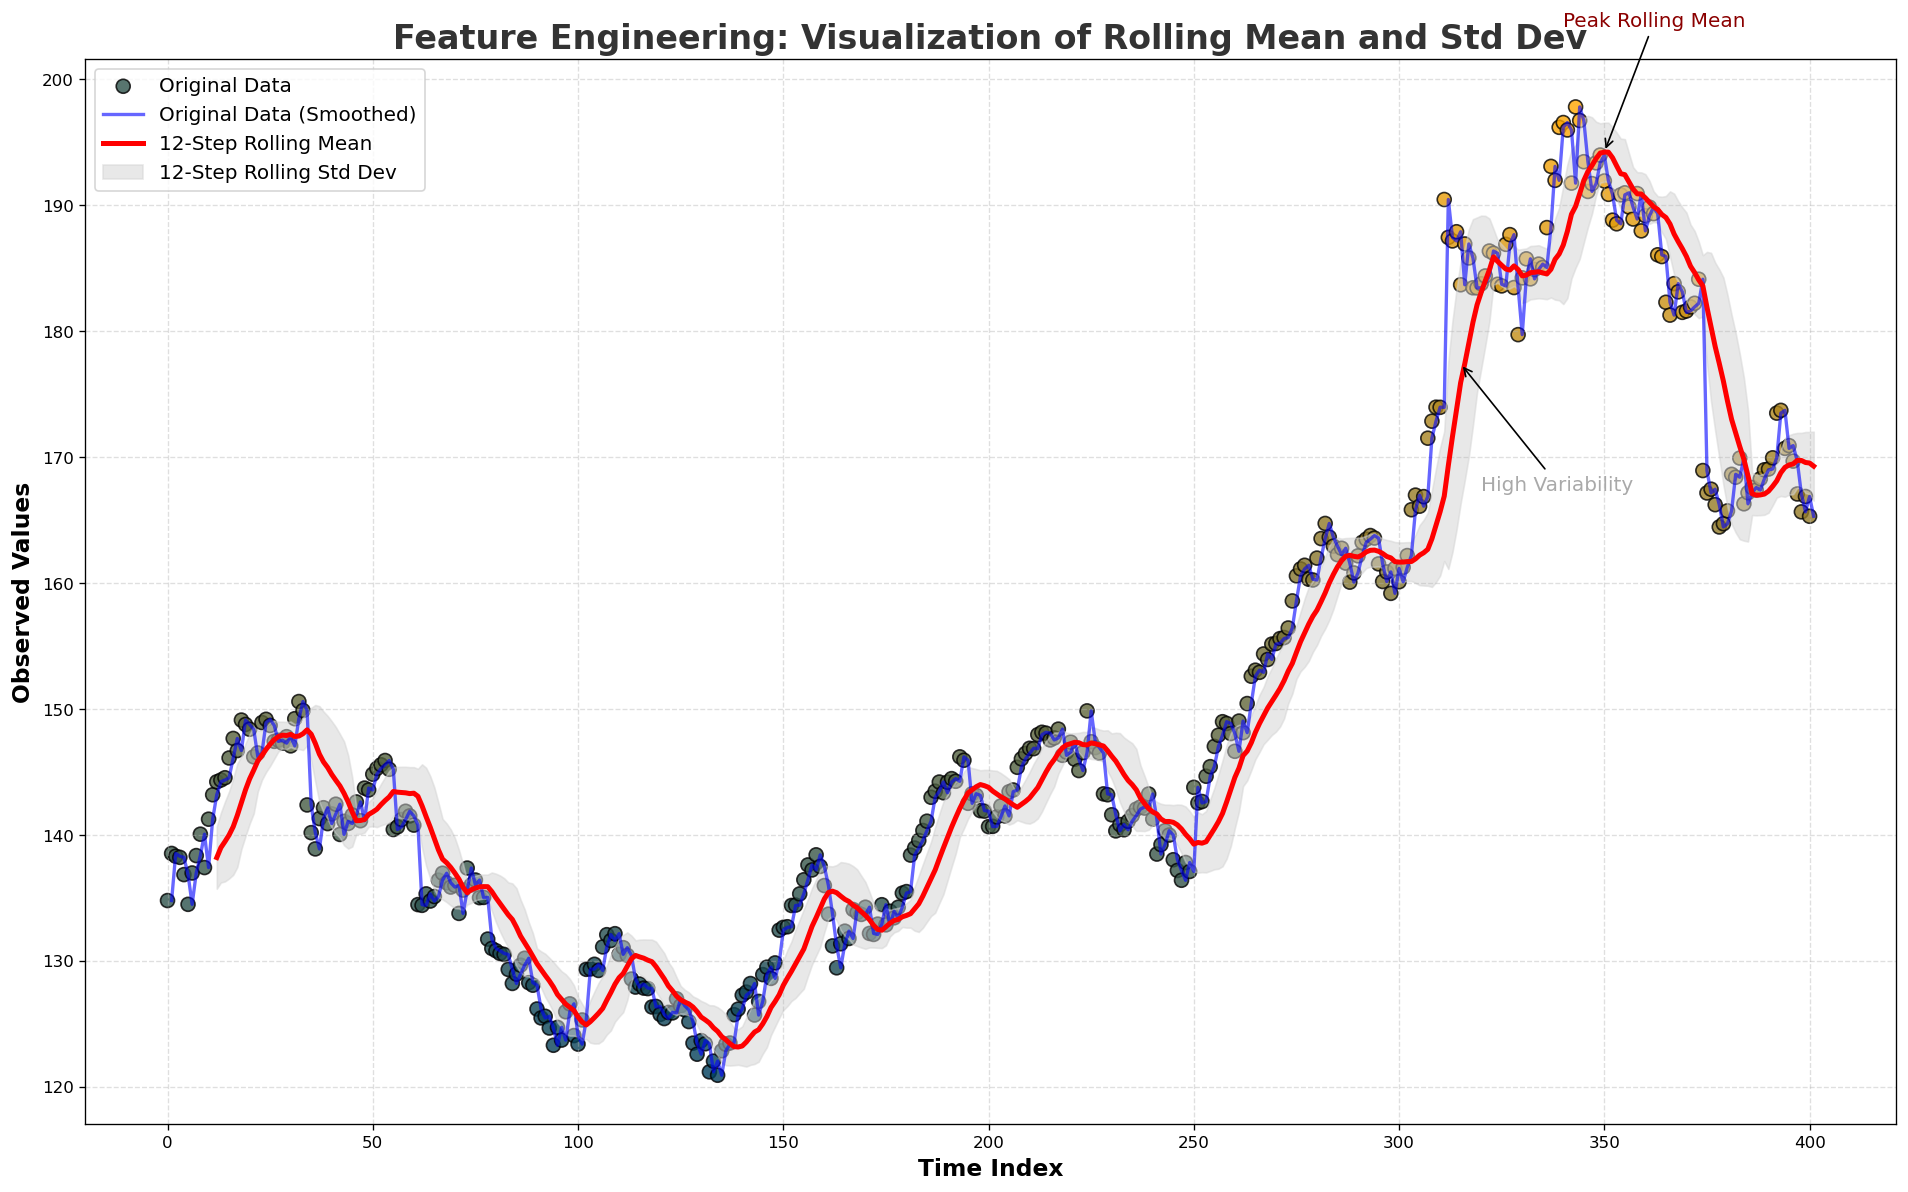

In [12]:
# Step 1: Create lag features
# Lag features help capture dependencies between the current value and past values.
time_series_data['Lag_1'] = time_series_data['Observed Values'].shift(1)

# Step 2: Calculate rolling mean and standard deviation
# Rolling Mean: Highlights trends by smoothing short-term fluctuations.
# Rolling Std Dev: Captures variability over a sliding window.
window_size = 12  # Define the rolling window size (e.g., 12 months for annual data)
time_series_data['Rolling_Mean'] = time_series_data['Observed Values'].rolling(window=window_size).mean()
time_series_data['Rolling_Std'] = time_series_data['Observed Values'].rolling(window=window_size).std()

# Step 3: Verify the new features
print("First few rows with newly engineered features (Lag, Rolling Mean, Rolling Std):")
print(time_series_data.head(15))

# Step 4: Visualize the original series, rolling mean, and rolling standard deviation

# Create a gradient color map for the original data points
gradient_cmap = LinearSegmentedColormap.from_list("gradient", ["#003f5c", "#ffa600"], N=100)

# Plot original data, rolling mean, and standard deviation bounds
plt.figure(figsize=(16, 10), dpi=120)

# Original Data: Use scatter plot with gradient styling
plt.scatter(
    range(len(time_series_data['Observed Values'])), 
    time_series_data['Observed Values'], 
    c=time_series_data['Observed Values'], cmap=gradient_cmap, 
    edgecolor='black', s=70, alpha=0.8, label='Original Data'
)
plt.plot(
    time_series_data['Observed Values'], 
    color='blue', linewidth=2, alpha=0.6, label='Original Data (Smoothed)'
)

# Rolling Mean: Plot as a bold red line
plt.plot(
    time_series_data['Rolling_Mean'], 
    color='red', linewidth=3, label=f'{window_size}-Step Rolling Mean'
)

# Rolling Std Dev: Plot as a shaded area
plt.fill_between(
    time_series_data.index, 
    time_series_data['Rolling_Mean'] - time_series_data['Rolling_Std'], 
    time_series_data['Rolling_Mean'] + time_series_data['Rolling_Std'], 
    color='lightgray', alpha=0.5, label=f'{window_size}-Step Rolling Std Dev'
)

# Annotate Key Points
# Highlight the peak of the rolling mean
rolling_mean_peak_idx = time_series_data['Rolling_Mean'].idxmax()
plt.annotate(
    'Peak Rolling Mean', 
    xy=(rolling_mean_peak_idx, time_series_data['Rolling_Mean'].max()), 
    xytext=(rolling_mean_peak_idx - 10, time_series_data['Rolling_Mean'].max() + 10), 
    arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12, color='darkred'
)

# Highlight a point of high variability (maximum rolling std deviation)
rolling_std_peak_idx = time_series_data['Rolling_Std'].idxmax()
plt.annotate(
    'High Variability', 
    xy=(rolling_std_peak_idx, time_series_data['Rolling_Mean'].iloc[rolling_std_peak_idx]), 
    xytext=(rolling_std_peak_idx + 5, time_series_data['Rolling_Mean'].iloc[rolling_std_peak_idx] - 10), 
    arrowprops=dict(facecolor='gray', arrowstyle='->'), fontsize=12, color='darkgray'
)

# Add Titles and Labels with Professional Styling
plt.title(
    'Feature Engineering: Visualization of Rolling Mean and Std Dev', 
    fontsize=20, fontweight='bold', color='#333'
)
plt.xlabel('Time Index', fontsize=14, fontweight='bold')
plt.ylabel('Observed Values', fontsize=14, fontweight='bold')

# Add Legend and Grid
plt.legend(fontsize=12, loc='upper left')
plt.grid(alpha=0.4, linestyle='--')

# Optimize Layout for Presentation
plt.tight_layout()
plt.show()


# 9. Find Optimal SARIMA Parameters (Auto ARIMA)

In [13]:
from pmdarima import auto_arima

def train_auto_arima(
    data,                # Input training data
    start_p=0, start_q=0, 
    max_p=3, max_q=3, 
    seasonal=True, 
    m=30, 
    d=1, D=1, 
    stepwise=True, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
):
    """
    Trains an Auto ARIMA model based on the given parameters.

    Args:
        data: The training data (time series) as a pandas Series or array.
        start_p (int): Initial AR order.
        start_q (int): Initial MA order.
        max_p (int): Maximum AR order.
        max_q (int): Maximum MA order.
        seasonal (bool): Whether to include seasonality.
        m (int): Seasonal period.
        d (int): Non-seasonal differencing order.
        D (int): Seasonal differencing order.
        stepwise (bool): Use stepwise approach for optimization.
        trace (bool): Enable tracing of progress.
        error_action (str): Action to take on errors.
        suppress_warnings (bool): Suppress warnings during fitting.

    Returns:
        A fitted auto_arima model.
    """
    model = auto_arima(
        data,
        start_p=start_p, start_q=start_q,
        max_p=max_p, max_q=max_q,
        seasonal=seasonal,
        m=m,
        d=d, D=D,
        stepwise=stepwise,
        trace=trace,
        error_action=error_action,
        suppress_warnings=suppress_warnings
    )
    return model

# Example usage:
train_data = train['Observed Values']
arima_model = train_auto_arima(data=train_data, m=30, max_p=5, max_q=5)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=1505.420, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=1370.268, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=1.13 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=1403.601, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=1354.129, Time=1.07 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=3.44 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=1450.269, Time=0.85 sec
 ARIMA(2,1,0)(2,1,0)[30]             : AIC=1323.191, Time=1.38 sec
 ARIMA(2,1,0)(1,1,0)[30]             : AIC=1341.215, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[30]             : AIC=inf, Time=4.58 sec
 ARIMA(2,1,0)(1,1,1)[30]             : AIC=inf, Time=1.79 sec
 ARIMA(3,1,0)(2,1,0)[30]             : AIC=1309.824, Time=1.74 sec
 ARIMA(3,1,0)(1,1,0)[30]             : AIC=1327.6

In [14]:
import pandas as pd
from IPython.display import display  # For Jupyter-style display of tables

# Extract model summary as a string
summary = arima_model.summary().as_text()

# Process the summary into structured data
summary_lines = summary.split("\n")
key_metrics = {
    "Metric": [],
    "Value": []
}

# Extract key metrics (adjust based on the model's output)
for line in summary_lines:
    if ":" in line:
        parts = line.split(":")
        key_metrics["Metric"].append(parts[0].strip())
        key_metrics["Value"].append(parts[1].strip())

# Convert metrics to a DataFrame
summary_df = pd.DataFrame(key_metrics)

# Display the DataFrame in a styled format
styled_table = summary_df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#404040'), ('color', 'white'), ('font-size', '14px'), ('text-align', 'center')]},
     {'selector': 'tbody td', 'props': [('text-align', 'center'), ('font-size', '12px'), ('border', '1px solid #ddd')]},
     {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]}]
).set_caption("Model Summary")

display(styled_table)


,Metric,Value
0,Dep. Variable,y No. Observations
1,Model,"SARIMAX(3, 1, 0)x(2, 1, [1], 30) Log Likelihood -641.299"
2,Date,"Sat, 30 Nov 2024 AIC 1296.598"
3,Time,21
4,Sample,0 HQIC 1306.882
5,Covariance Type,opg
6,Ljung-Box (L1) (Q),0.95 Jarque-Bera (JB)
7,Prob(Q),0.33 Prob(JB)
8,Heteroskedasticity (H),1.41 Skew
9,Prob(H) (two-sided),0.09 Kurtosis


# 10. Generate Forecasts

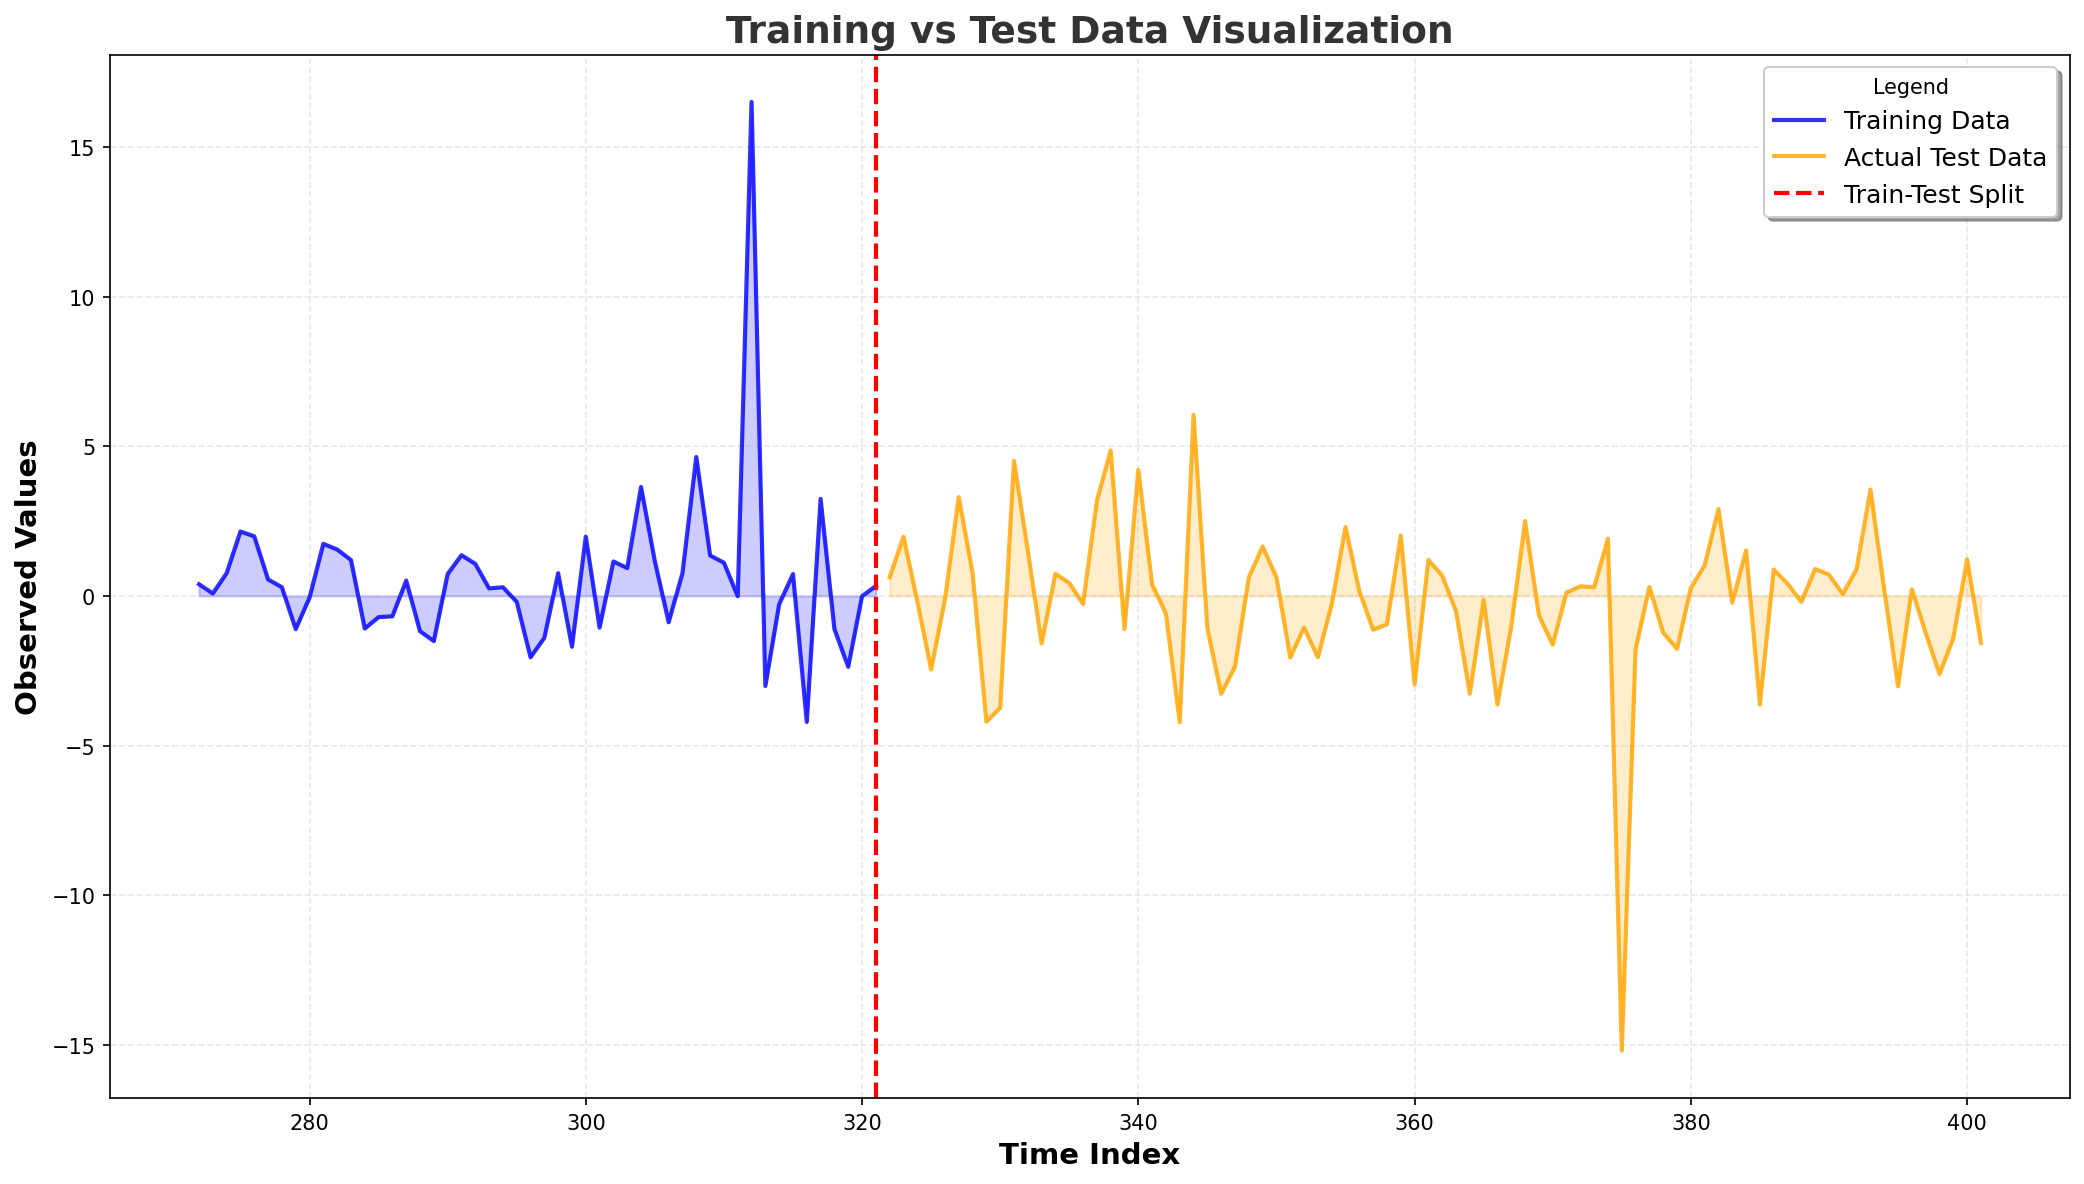

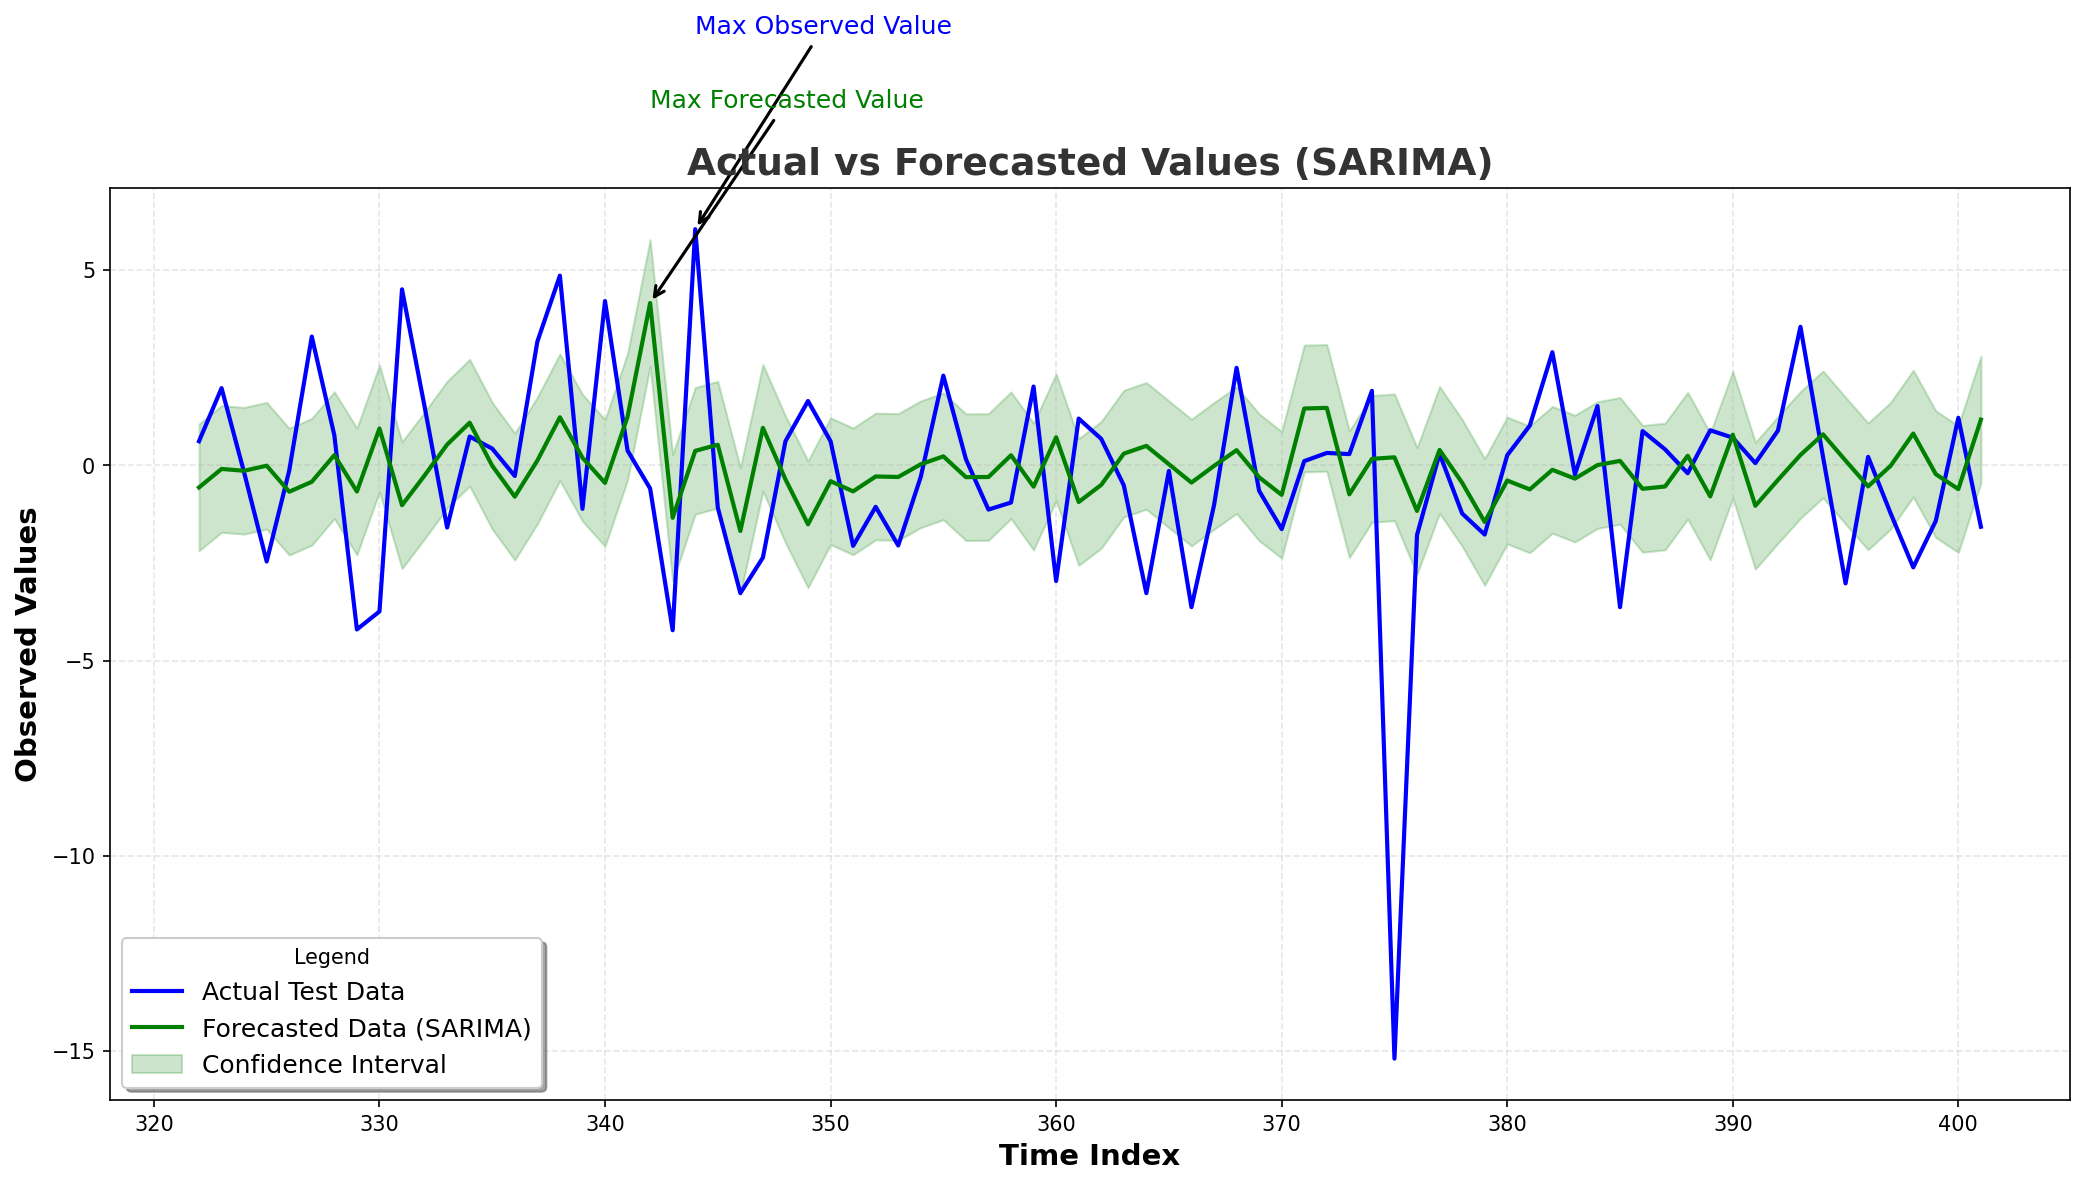


### Model Performance Metrics:
- **Root Mean Squared Error (RMSE):** 2.8217
- **Mean Absolute Error (MAE):** 1.9620


In [15]:
# Import required libraries
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Fit the model on the training data
arima_model.fit(train['Observed Values'])

# Generate forecasts for the test period
forecast = arima_model.predict(n_periods=len(test))

# Define a gradient color map for advanced styling
cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#003f5c", "#ffa600"], N=100)

# Visualization 1: Training and Test Data with Style Enhancements
plt.figure(figsize=(14, 8), dpi=150)

# Training data with gradient fill
plt.plot(train.index[-50:], train['Observed Values'][-50:], label='Training Data', color='blue', linewidth=2, alpha=0.8)
plt.fill_between(train.index[-50:], train['Observed Values'][-50:], alpha=0.2, color="blue")

# Test data with gradient fill
plt.plot(test.index, test['Observed Values'], label='Actual Test Data', color='orange', linewidth=2, alpha=0.8)
plt.fill_between(test.index, test['Observed Values'], alpha=0.2, color="orange")

# Highlight train-test split
split_point = train.index[-1]
plt.axvline(split_point, color='red', linestyle='--', linewidth=2, label='Train-Test Split')

# Title and Labels
plt.title("Training vs Test Data Visualization", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Time Index", fontsize=14, fontweight='bold')
plt.ylabel("Observed Values", fontsize=14, fontweight='bold')

# Grid, Legend, and Layout
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12, frameon=True, shadow=True, loc='best', title="Legend")
plt.tight_layout()
plt.show()

# Visualization 2: Actual vs Forecasted Values
plt.figure(figsize=(14, 8), dpi=150)

# Actual test data
sns.lineplot(x=test.index, y=test['Observed Values'], color="blue", label="Actual Test Data", linewidth=2)

# Forecasted data with a ribbon effect for confidence intervals
sns.lineplot(x=test.index, y=forecast, color="green", label="Forecasted Data (SARIMA)", linewidth=2)
plt.fill_between(test.index, forecast - 1.96 * np.std(forecast), forecast + 1.96 * np.std(forecast), 
                 color="green", alpha=0.2, label="Confidence Interval")

# Annotate key points
# Maximum observed value in test data
max_actual_idx = test['Observed Values'].idxmax()
plt.annotate(
    "Max Observed Value", 
    xy=(max_actual_idx, test['Observed Values'].max()), 
    xytext=(max_actual_idx, test['Observed Values'].max() + 5),
    arrowprops=dict(facecolor="blue", arrowstyle="->", linewidth=1.5),
    fontsize=12, color="blue"
)

# Maximum forecasted value
max_forecast_idx = test.index[np.argmax(forecast)]
plt.annotate(
    "Max Forecasted Value", 
    xy=(max_forecast_idx, max(forecast)), 
    xytext=(max_forecast_idx, max(forecast) + 5),
    arrowprops=dict(facecolor="green", arrowstyle="->", linewidth=1.5),
    fontsize=12, color="green"
)

# Title and Labels
plt.title("Actual vs Forecasted Values (SARIMA)", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Time Index", fontsize=14, fontweight='bold')
plt.ylabel("Observed Values", fontsize=14, fontweight='bold')

# Grid, Legend, and Layout
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12, frameon=True, shadow=True, loc='best', title="Legend")
plt.tight_layout()
plt.show()

# Performance Metrics: Styled Print
from IPython.display import display, Markdown
mse = mean_squared_error(test['Observed Values'], forecast)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(test['Observed Values'], forecast)  # Mean Absolute Error

# Print performance metrics in Markdown
display(Markdown(f"""
### Model Performance Metrics:
- **Root Mean Squared Error (RMSE):** {rmse:.4f}
- **Mean Absolute Error (MAE):** {mae:.4f}
"""))


In [21]:
import numpy as np

def calculate_mape(actual, predicted):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    
    Parameters:
    - actual: array-like, true values
    - predicted: array-like, predicted values
    
    
    Returns:
    - mape: float, Mean Absolute Percentage Error
    """
    actual, predicted = np.array(actual), np.array(predicted)
    # Avoid division by zero by replacing 0 in actual with a small value
    epsilon = np.finfo(np.float64).eps
    actual = np.where(actual == 0, epsilon, actual)
    
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

# Example usage
actual = [100, 200, 300, 400, 500]
predicted = [110, 190, 290, 410, 490]

mape = calculate_mape(actual, predicted)
print(f"MAPE: {mape:.2f}%")





MAPE: 4.57%
